 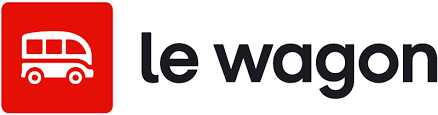

# Instagram likes prediction

We would like to predict the Greenweez turnover based on its past values

➡️ We have access to the sales from 2019 to 2021.

## Load data

a) Execute the cell below to load the data into `df` variable.

What does this SQL query do?

In [1]:
import pandas as pd
from google.cloud import bigquery

client = bigquery.Client()

In [2]:
query = """
SELECT
    DATE_TRUNC(date_date, day) AS day,
    SUM(turnover) as turnover
FROM `lewagon1390.raw_gwz.sales`
GROUP BY day
ORDER by day
"""

In [3]:
query_results = client.query(query)  

In [3]:
df = client.query(query).to_dataframe()

In [4]:
df

,day,turnover
0,2019-01-01,44701.68
1,2019-01-02,70769.80
2,2019-01-03,63244.24
3,2019-01-04,57895.95
4,2019-01-05,57288.99
...,...,...
1091,2021-12-27,59637.44
1092,2021-12-28,55751.96
1093,2021-12-29,51504.27
1094,2021-12-30,58154.98


This SQL query calculates daily turnover.


b) Plot turnover overtime using `plotly.express`.

Do you see any seasonality?

In [ ]:
import plotly.express as px

fig = px.line(df, "day", "turnover")
fig.show()

We can detect seasonality on this time serie : turnover drops at the end of each year.

We will try to predict the last month on December based on previous data.

## Using ARIMA model

a) Execute cell below to install missing packages

In [ ]:
!pip install sktime -q
!pip install pmdarima -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.0 MB/s eta 0:00:00


b) Let's keep the last month on December 2021 as the test set to evaluate our prediction. We will set `test_size` parameter to 30.

You can use pandas functions or `temporal_train_test_split` from `sktime.forecasting.model_selection` to split our data into train and test.

Name them `df_train` and `df_test`


In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split

df_train, df_test = temporal_train_test_split(df, test_size=30)

/usr/local/lib/python3.10/dist-packages/sktime/__init__.py:45: PackageDeprecationWarning:


The sktime PyPI package is deprecated.
The sktime project split into two projects.

To find out how to install the new packages, please go to:

* https://github.com/aeon-toolkit/aeon
* https://github.com/sktime/sktime

Here is what you can do when installing sktime via pip (e.g. using `pip install ...` or a requirement file like `requirements.txt`, `setup.py`, `setup.cfg`):

* continue using the package without receiving any updates (ignoring the deprecation warning or avoiding it by pinning the version: `sktime==0.18.0`),
* replace sktime with one of the new projects,
* if the sktime package is used by one of your dependencies, it would be great if you take some time to track which package uses sktime and report to their issue tracker that sktime is deprecated.

More information is available at:
https://github.com/mloning/sktime-deprecation/discussions/2

If the previous advice does not support

c) AutoARIMA is a module to search for best parameters and will fit to the best model. Use this model to fit your training data.

In [ ]:
from sktime.forecasting.arima import AutoARIMA

arima = AutoARIMA()
arima.fit(df_train['turnover'])

AutoARIMA()

d) Plot the `arima.summary()` to check the best parameters.

What is the model obtained?

In [ ]:
# best model here is SARIMAX(0, 1, 2)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1066
Model:               SARIMAX(0, 1, 2)   Log Likelihood              -12015.955
Date:                Mon, 29 May 2023   AIC                          24037.911
Time:                        13:07:25   BIC                          24052.823
Sample:                             0   HQIC                         24043.561
                               - 1066                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4044      0.021    -18.922      0.000      -0.446      -0.363
ma.L2         -0.3749      0.026    -14.566      0.000      -0.425      -0.324
sigma2      3.658e+08   1.62e-11   2.26e+19      0.000    3.66e+08    3.66e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              2032.74
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.59   Skew:                             1.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.75e+34. Standard errors may be unstable.
"""

e) Our model is now ready to make a forecast using the method `predict`.
Assign the prediction for the df_test to a `pred_arima` variable.

<details>
    <summary><i>Hint</i></summary>
`predict` method accepts a forecast horizon like [1,2,3,4,5,6...]. If you want to predict 30 days, make it 30 with range function!
</details>

In [ ]:
pred_arima = arima.predict(list(range(1,31)))

f) Let's add the prediction to the `df_test` dataset as a new column `pred_arima`

In [ ]:
df_test["pred_arima"] = pred_arima

g) Using Plotly express `px.line()`, plot turnover and predicted turnover. Do you think the model is a good one?

You can pass `df_test.set_index(day)` directly to the function. This way you don't need add_trace.

In [ ]:
import plotly.express as px

fig = px.line(df_test.set_index("day"))
fig.show()

h) The metric **Mean Absolute Percentage Error (MAPE)** is used to compare performance on time series.
This metric is the one used by the method `score`. Assign it to the variable `score_arima`.

Is this metric better if it's bigger or smaller?

In [ ]:
score_arima=arima.score(df_test['turnover'])
score_arima

0.8828367546069178

88%, the model is pretty bad...
MAPE should be close to 0.

Arima model needs to be tuned to perform better.

## Using PROPHET model

a) Start by installing greykite library on Colab.

For that, execute the cell below.

In [ ]:
!pip install greykite -q
!pip install holidays==0.24

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.9/499.9 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: holidays
    Found existing installation: holidays 0.25
    Uninstalling holidays-0.25:
      Successfully uninstalled holidays-0.25


b) Import the libraries

In [ ]:
import datetime

from greykite.framework.templates.autogen.forecast_config import ForecastConfig, MetadataParam, ModelComponentsParam
from greykite.framework.templates.forecaster import Forecaster

c) We want to use the PROPHET model from Facebook to train our model and make a prediction for future turnover.

We want to use the same trainning values than our first ARIMA model (values until 1st Dec 2021) and test our prediction with the same values (month of December 2021).

Create a forecastconfig in a `config` variable with correct parameters. See today's lesson for the syntax.

<details>
    <summary><i>Solution:</i></summary>
    
`config = ForecastConfig(
     metadata_param=MetadataParam(
      time_col = "day",
      value_col = "turnover",
      freq="D",
      train_end_date = datetime.datetime(2021, 12, 1)),
     model_template="PROPHET",
     forecast_horizon=30,
     coverage=0.95)`
</details>

In [ ]:
config = ForecastConfig(
     metadata_param=MetadataParam(
      time_col = "day",
      value_col = "turnover",
      freq="D",
      train_end_date = datetime.datetime(2021, 12, 1)),
     model_template="PROPHET",
     forecast_horizon=30,
     coverage=0.95)

d) Train your model.

See today's lesson for the syntax.

In [ ]:
forecaster = Forecaster()
result = forecaster.run_forecast_config(df=df, config=config)
# model_prophet = result.model

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3twvh55/pflc01ek.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3twvh55/ecoo8g6e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42951', 'data', 'file=/tmp/tmpm3twvh55/pflc01ek.json', 'init=/tmp/tmpm3twvh55/ecoo8g6e.json', 'output', 'file=/tmp/tmpm3twvh55/prophet_modelz4a38vzz/prophet_model-20230529130749.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:07:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:08:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3twvh55/zp3vnyx6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3twvh55/klooqf57.json
DEBUG:cmdstanpy

e) We can access the result of the prediction with `result.forecast` and we can evaluate the performance with `result.forecast.test_evalution`.

Find the same metric as the Arima model and assign it to a `score_prophet` variable. Is this model better than ARIMA?

In [ ]:
score_prophet = result.forecast.test_evaluation['MAPE']
score_prophet

30.992503778634074

The model is much better!

f) The Greykite library has its own plot function which incorporates the upper and lower bounds of the prediction.

Don't forget that you can zoom in on the graph. Run the cell below to see the results!

In [ ]:
result.forecast.plot()

## Using custom PROPHET model

g) The Facebook Prophet model allows us to integrate holidays and seasonality to the algorithm.
Try to query the table `sales` in BigQuery to find out in which country the higher number of sales is made.
In the model we will integrate the holidays of the country in which the most sales were made
Do not erase your `df` dataset, choose another name!

In [ ]:
query = '''
SELECT country, count(*) as sum_sales
FROM `data-analytics-bootcamp-363212.raw_gwz.sales`
GROUP BY country ORDER by sum_sales DESC  LIMIT 3
'''
country_sales = pd.read_gbq(query, project_id="data-analytics-bootcamp-363212")
country_sales

,country,sum_sales
0,FRANCE,8591471
1,BELGIQUE,162452
2,SUISSE,28232


h) We will need a new `ForecastConfig`. Copy the `ForecastConfig` you made before, and add a new argument inside ForecastConfig() called `model_components_param=`. Its value should be a `ModelComponentsParam()` with:
- `seasonality = { your_code_here }`
- `events = { your_code_here })`

See your lecture for correct syntax

<details>
    <summary><i>Hint for seasonality</i></summary>
We understand from plotting the data that we have yearly seasonality. Set the `yearly_seasonality` to `True`
</details>        

In [ ]:
config_holidays = ForecastConfig(
    metadata_param = MetadataParam(
      time_col = "day",
      value_col = "turnover",
      train_end_date = datetime.datetime(2021, 12, 1)),
    model_template = "PROPHET",
    forecast_horizon = 30,
    coverage = 0.95,
    model_components_param = ModelComponentsParam(
     seasonality={"yearly_seasonality": True},
     events = {
         "holiday_lookup_countries": ["France", "Belgium", "Switzerland"],
         "holiday_pre_num_days": [0],
         "holiday_post_num_days": [0],
     }))

i) Train a new facebook prophet model from this new configuration and store it in `result_custom` variable.

In [ ]:
result_custom = Forecaster().run_forecast_config(df = df, config = config_holidays)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3twvh55/7tipfq85.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3twvh55/_8es50n5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


Fitting 3 folds for each of 1 candidates, totalling 3 fits


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90822', 'data', 'file=/tmp/tmpm3twvh55/7tipfq85.json', 'init=/tmp/tmpm3twvh55/_8es50n5.json', 'output', 'file=/tmp/tmpm3twvh55/prophet_model2futcjmx/prophet_model-20230529130826.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:08:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:08:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3twvh55/oyqwfogp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm3twvh55/hr5139cq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29722', 'data'

j) Assign the MAPE to the variable `score_prophet_custom`.

Is it a better model?

In [ ]:
score_prophet_custom = result_custom.forecast.test_evaluation['MAPE']
score_prophet_custom

22.24965351639522

Yes, it's the best model yet.

k) plot forecast, what do you think about this result?

In [ ]:
result_custom.forecast.plot()

The predictions seems be quite good. They are close to the actual values, and we see that the actual values are all within the plotted confidence interval.

# Time series decomposition

Prophet model will forecast based on decomposition of the time serie with simple elements:
- trend
- holidays
- seasonality

l) For compatibility reasons, run the cell below to install the correct version of matplotlib.

Don't worry if you get red lines, your computer likes jokes :) and don't click on restart runtime.

In [ ]:
!python -m pip uninstall -y matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.7.1
Uninstalling matplotlib-3.7.1:
  Successfully uninstalled matplotlib-3.7.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 MB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.1.3-cp310-cp310-linux_x86_64.whl size=12068472 sha256=dd06d737feef0f93ed0811139dad85c2380da8fd2889e59579161ec951cf930e
  Stored in directory: /root/.cache/pip/wheels/a7/83/5a/c704868d367ace343ac89b928f3d937313a5b5fb5731483705
Successfully built matplotlib
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.15.1 requires matplotlib>=3.2, but you have matplotlib 3.1.3 which is incompatible.
greykite 0.5.0 requires matplotlib>=3.4.1, but you have matplotlib 3.1.3 which is

m) Run the cell below to see all the learned components of the `result_custom` model. What do you see?

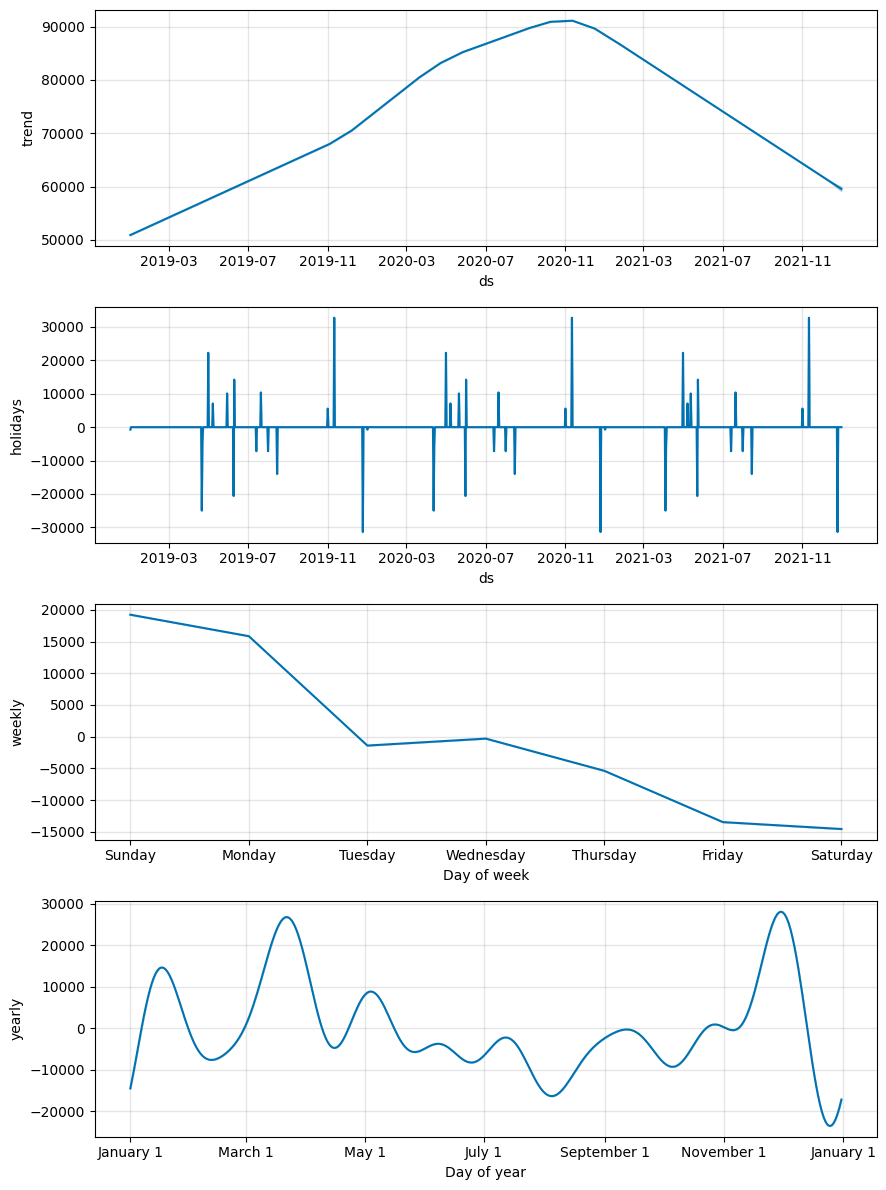

In [ ]:
result_custom.forecast.plot_components()


The trend clearly shows that sales rose in the period to 19 October and are now beginning to fall.
Public holidays play an important role in the forecasts.
Not all days are the same; Sundays are order days.
The annual graph shows the annual seasonality of the data.